# Final experiments: varying entrainment rate

Thomas Schanzer z5310829  
School of Physics, UNSW  
November 2021

In this notebook, we vary the initial conditions for a parcel in a fixed, idealised sounding and fixed entrainment rate.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update(
    {'font.size': 16, 'text.usetex': True, 'font.family': 'serif',
     'font.serif': ['Computer Modern Roman']})

import metpy.calc as mpcalc
from metpy.units import units
import metpy.constants as const
from metpy.units import concatenate
from metpy.plots import SkewT

import sys
from os import mkdir
from os.path import exists

sys.path.append('../../scripts/')
from environment import idealised_sounding
from thermo import moist_lapse, saturation_specific_humidity, dcape_dcin
from thermo import temperature_change
from entraining_parcel import EntrainingParcel

In [2]:
fig_path = '20211110_varying_initial_conditions_figures/'
if not exists(fig_path):
    mkdir(fig_path)

In [3]:
sounding = idealised_sounding(0.5)
parcel = EntrainingParcel(sounding)

## Experiments

In [4]:
z_initial = 5*units.km
w_initial = 0*units.meter/units.second
p_initial = sounding.pressure(z_initial)

env_q = sounding.specific_humidity(z_initial)
max_dq = sounding.maximum_specific_humidity_change(z_initial)
wetbulb = sounding.wetbulb_temperature(z_initial)
q_initial = concatenate(
    (np.linspace(env_q, env_q + max_dq, 11)[1:-1],
     np.ones(11)*saturation_specific_humidity(p_initial, wetbulb)))
l_initial = concatenate((np.zeros(10), np.linspace(0, 2e-3, 11)[1:]))
t_initial = concatenate((
    sounding.temperature(z_initial)
    + temperature_change(q_initial[0:9] - env_q),
    np.ones(11)*wetbulb))

time = np.arange(0, 10.1, 0.01)*units.minute
rate = 1/units.km

In [12]:
%%time
sols = []
i = 0
for t, q, l in zip(t_initial, q_initial, l_initial):
    sys.stdout.write('\rCalculation {} of {}    '.format(i+1, t_initial.size))
    sol = parcel.motion(
        time, z_initial, w_initial, t, q, l, rate, kind='reversible')
    sols.append(sol)
    i += 1
sys.stdout.write('\n')

Calculation 20 of 20    
CPU times: user 2min 31s, sys: 891 ms, total: 2min 32s
Wall time: 2min 34s


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


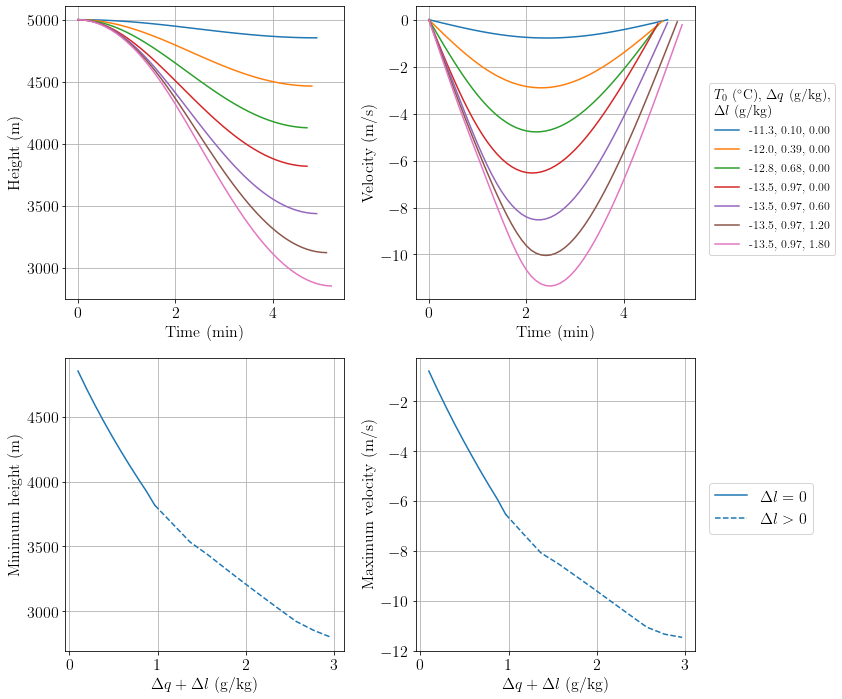

In [53]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(221)
for sol, t, q, l in zip(
        sols[::3], t_initial[::3], q_initial[::3], l_initial[::3]):
    ax.plot(time, sol.height)
ax.grid()
ax.set(
    xlabel='Time (min)',
    ylabel='Height (m)')

ax = fig.add_subplot(222)
for sol, t, q, l in zip(
        sols[::3], t_initial[::3], q_initial[::3], l_initial[::3]):
    ax.plot(
        time, sol.velocity,
        label='{:.1f}, {:.2f}, {:.2f}'.format(t.m, (q - env_q).m*1e3, l.m*1e3))
lgd = ax.legend(loc=[1.05, 0.15], fontsize=12, title_fontsize=14)
lgd.set_title('$T_0$ ($^\circ$C), $\Delta q$ (g/kg),\n$\Delta l$ (g/kg)')
ax.grid()
ax.set(
    xlabel='Time (min)',
    ylabel='Velocity (m/s)')

ax = fig.add_subplot(223)
ax.plot(
    [(q - env_q + l).m*1e3 for q, l in zip(q_initial[:10], l_initial[:10])],
    [sol.min_height.m for sol in sols[:10]], color='tab:blue')
ax.plot(
    [(q - env_q + l).m*1e3 for q, l in zip(q_initial[9:], l_initial[9:])],
    [sol.min_height.m for sol in sols[9:]], '--', color='tab:blue')
ax.grid()
ax.set(
    xlabel='$\Delta q + \Delta l$ (g/kg)',
    ylabel='Minimum height (m)')

ax = fig.add_subplot(224)
ax.plot(
    [(q - env_q + l).m*1e3 for q, l in zip(q_initial[:10], l_initial[:10])],
    [np.nanmin(sol.velocity.m) for sol in sols[:10]], color='tab:blue',
    label='$\Delta l = 0$')
ax.plot(
    [(q - env_q + l).m*1e3 for q, l in zip(q_initial[9:], l_initial[9:])],
    [np.nanmin(sol.velocity.m) for sol in sols[9:]], '--', color='tab:blue',
    label='$\Delta l > 0$')
ax.legend(loc=[1.05, 0.4])
ax.grid()
ax.set(
    xlabel='$\Delta q + \Delta l$ (g/kg)',
    ylabel='Maximum velocity (m/s)')

fig.tight_layout()
fig.savefig(fig_path + 'motion_vs_initial_conditions_50RH_1perkm.eps',
            facecolor='w', bbox_inches='tight')
plt.show()